In [1]:
import os
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from arch import arch_model
from tqdm import tqdm
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import logging

from validate_pipeline import run_full_validation
from dataprocessing import build_features

In [161]:
# -----------------------
# Reproducibility
# -----------------------
SEED = 0
np.random.seed(SEED)
# xgboost uses seed param inside params
# -----------------------
# Logging
# -----------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger("vol_demo")

In [162]:
X = pd.read_csv('/home/tatiana/Downloads/supp_material/X_train.csv')
Y = pd.read_csv('/home/tatiana/Downloads/supp_material/y_train.csv')
X_test = pd.read_csv('/home/tatiana/Downloads/supp_material/X_test.csv')

df = build_features(X, Y, add_target=True)   # training
df_TEST = build_features(X_test, None, add_target=False)  # test / prediction

In [79]:
df['DAY_ID'], df_TEST['DAY_ID']

(0          2
 1          3
 2          5
 3          7
 4          8
         ... 
 1489    1208
 1490    1209
 1491    1212
 1492    1213
 1493    1215
 Name: DAY_ID, Length: 1494, dtype: int64,
 0         4
 1         6
 2         9
 3        13
 4        24
        ... 
 649    1203
 650    1206
 651    1210
 652    1211
 653    1214
 Name: DAY_ID, Length: 654, dtype: int64)

## Data description
- This data was taken from a ML challenge competition, therefore I am not sure I can freely post the datasets. In case of interest, you can easily retrieve the data here: https://challengedata.ens.fr/participants/challenges/97/ 
- X contains 35 columns of self-explanatory exogenous variables related to a coupled power market of France and Germany. See print of the variables names here:
  ['ID', 'DAY_ID', 'COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'FR_DE_EXCHANGE', 'DE_NET_EXPORT', 'FR_NET_EXPORT', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET']

- Y contains price changes for daily futures contracts of 24H electricity baseload for these countries. X and Y datasets have an 'ID' variable as a common identifier.
- Attention! ID != DAY_ID, therefore I sorted them first by ID, then just merged sorted X and Y into one Dataframe, then sorted by DAY_ID to set the time sequence correctly.
- Some days contain information for both countries, some only for FR or DE. Needs to be taken into account when computing lags per country etc.
- Please see all manipulations and engineered features additions in dataprocessing.py file containing build_features function, here I already use the resulting dataframe.

## Engineered features block

- Not all of them should used, here are just ideas to be tested. Too many -- bad, too few -- also not good.
- Features should be chosen based on what the ML model CAN properly learn. Mostly monotonic persistent relationships. That is:
    - Likely not weather spikes (so no raw weather data)
    - Likely not individual power outages
    - Likely not market news jumps
- But rather structural stress variables:
    - Volatility lags themselves, as long as volatility memory is there
    - System stress
    - Cross-border congestion
    - Fuel/merit order shocks
    - Renewable penetration regime 

## GARCH part

In [163]:
# -----------------------
# GARCH rolling forecast per country (leak-free) - keep start/end indices explicit
# -----------------------
garch_window = 500
min_obs = 300

# Create garch_vol and store successful fit count
df = df.sort_values(['COUNTRY','DAY_ID']).reset_index(drop=True)
df['garch_vol'] = np.nan
#df['garch_stdresid'] = np.nan  # standardized residual

for country in df['COUNTRY'].unique():
    df_c_idx = df[df['COUNTRY']==country].index
    returns = df.loc[df_c_idx, 'volatility'].values

    success_count = 0
    for local_t in range(len(returns)):
        if local_t < min_obs:
            continue
        start = max(0, local_t - garch_window)
        end = local_t  # up to t-1
        window = returns[start:end]
        if len(window) < min_obs:
            continue
        try:
            am = arch_model(window, vol='Garch', p=1, q=1, dist='t', rescale=False)
            res = am.fit(disp='off', update_freq=0, show_warning=False)
            fcast = res.forecast(horizon=1, reindex=False)
            sigma_t = np.sqrt(fcast.variance.values[-1,0])
            # place into global df at corresponding index
            global_idx = df_c_idx[start + (len(window))] if False else df_c_idx[local_t]
            df.loc[df_c_idx[local_t], 'garch_vol'] = sigma_t
            # compute standardized residual for local_t (current observed vol / sigma)
            #std_resid = returns[local_t] / (sigma_t + eps)
            #df.loc[df_c_idx[local_t], 'garch_stdresid'] = std_resid
            #success_count += 1
        except Exception as e:
            # log once per exception type if needed
            continue
    success_count = df.loc[df['COUNTRY']==country, 'garch_vol'].notna().sum()
    log.info(f'Country {country}: successful GARCH preds: {int(success_count)}')

# Drop rows without garch forecast (cannot build residual)
df = df.dropna(subset=['garch_vol']).reset_index(drop=True)
log.info(f'After dropping NaN garch_vol rows, {len(df)} observations remain')

2026-02-05 21:15:05,542 INFO Country DE: successful GARCH preds: 343
2026-02-05 21:15:32,103 INFO Country FR: successful GARCH preds: 551
2026-02-05 21:15:32,105 INFO After dropping NaN garch_vol rows, 894 observations remain


## ML part

In [164]:
# raw residual
df['residual_target'] = df['volatility'] - df['garch_vol']

# optional smoothed target for experiments, backwards smoothing --> no data leakage
df['residual_target_smooth'] = (
    df.groupby('COUNTRY')['residual_target']
      .transform(lambda x: x.shift(1).rolling(5, min_periods=1).mean())
)

In [165]:
FEATURE_POOL = [
    # Vol memory
    'vol_lag1','vol_lag3','vol_lag7',
    'vol_roll_std_7','vol_roll_std_30',

    # Load & imbalance
    'DE_RESIDUAL_LOAD_lag1','FR_RESIDUAL_LOAD_lag1',
    'LOAD_IMBALANCE','FLOW_PRESSURE','TOTAL_FLOW',
    'DE_RESIDUAL_STRESS','FR_RESIDUAL_STRESS', 'WIND_IMBALANCE', 'SOLAR_IMBALANCE', 'NUCLEAR_IMBALANCE',

    # Fuel / carbon
    'GAS_COAL_SPREAD','CARBON_PRESSURE',

    # Renewables
    'REL_RENEWABLE',

    # Regimes
    'GAS_RET_30m','LOAD_TREND_30' , 'LOADxGAS',

    'DE_TEMP_ANOM', 'FR_TEMP_ANOM', 'DE_WIND_ANOM', 'FR_WIND_ANOM', 'DE_RAIN_ANOM', 
    'FR_RAIN_ANOM', 'DE_RESIDUAL_LOAD_rm_3', 'DE_RESIDUAL_LOAD_std_3', 'DE_RESIDUAL_LOAD_rm_7',
    'DE_RESIDUAL_LOAD_std_7', 'DE_RESIDUAL_LOAD_rm_30', 'DE_RESIDUAL_LOAD_std_30', 
    'FR_RESIDUAL_LOAD_rm_3', 'FR_RESIDUAL_LOAD_std_3', 'FR_RESIDUAL_LOAD_rm_7', 'FR_RESIDUAL_LOAD_std_7', 
    'FR_RESIDUAL_LOAD_rm_30', 'FR_RESIDUAL_LOAD_std_30',
]


In [166]:
def score_features_production(feature_subset, df, train_window, test_horizon, params):
    rhos = []
    unique_days = np.sort(df['DAY_ID'].unique())

    for i in range(train_window, len(unique_days) - test_horizon + 1, test_horizon):

        train_days = unique_days[i-train_window:i]
        test_days  = unique_days[i:i+test_horizon]

        tr = df['DAY_ID'].isin(train_days)
        te = df['DAY_ID'].isin(test_days)

        X_tr = df.loc[tr, feature_subset]
        y_tr = df.loc[tr, 'residual_target']

        X_te = df.loc[te, feature_subset]
        y_te = df.loc[te, 'residual_target']

        # Drop NaNs
        mask_tr = y_tr.notna()
        mask_te = y_te.notna()

        X_tr, y_tr = X_tr.loc[mask_tr], y_tr.loc[mask_tr]
        X_te, y_te = X_te.loc[mask_te], y_te.loc[mask_te]

        if len(X_tr) < 200 or len(X_te) < 20:
            continue

        # ---- time-ordered validation split ----
        split = int(0.85 * len(X_tr))
        X_tr2, y_tr2 = X_tr.iloc[:split], y_tr.iloc[:split]
        X_val, y_val = X_tr.iloc[split:], y_tr.iloc[split:]

        dtr2 = xgb.DMatrix(X_tr2, label=y_tr2)
        dval = xgb.DMatrix(X_val, label=y_val)
        dte  = xgb.DMatrix(X_te)

        model = xgb.train(
            params,
            dtr2,
            num_boost_round=2000,
            evals=[(dtr2, 'train'), (dval, 'val')],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        preds = model.predict(dte)
        rho = spearmanr(preds, y_te).correlation

        if not np.isnan(rho):
            rhos.append(rho)

    if len(rhos) == 0:
        return -1

    return float(np.mean(rhos))

In [ ]:
params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.02,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 20,
    'alpha': 5,
    'min_child_weight': 30,
    'seed': SEED
}

In [168]:
selected = []
remaining = FEATURE_POOL.copy()
best_score = -1

while len(remaining) > 0:
    scores = []

    for f in remaining:
        trial = selected + [f]
        s = score_features(trial, df, train_window, test_horizon, params)
        scores.append((f, s))
        print(f'Trying {trial} → {s:.4f}')

    f_best, s_best = max(scores, key=lambda x: x[1])

    if s_best > best_score + 0.01:   # require improvement
        selected.append(f_best)
        remaining.remove(f_best)
        best_score = s_best
        print(f'ADD {f_best} → {best_score:.4f}\n')
    else:
        break

print("\nFINAL FEATURE SET:", selected)
print("FINAL SCORE:", best_score)

Trying ['vol_lag1'] → 0.1521
Trying ['vol_lag3'] → 0.1589
Trying ['vol_lag7'] → 0.0989
Trying ['vol_roll_std_7'] → 0.1612
Trying ['vol_roll_std_30'] → 0.2173
Trying ['DE_RESIDUAL_LOAD_lag1'] → -0.0030
Trying ['FR_RESIDUAL_LOAD_lag1'] → -0.0340
Trying ['LOAD_IMBALANCE'] → -0.0839
Trying ['FLOW_PRESSURE'] → -0.1057
Trying ['TOTAL_FLOW'] → -0.0935
Trying ['DE_RESIDUAL_STRESS'] → -0.0090
Trying ['FR_RESIDUAL_STRESS'] → -0.0040
Trying ['WIND_IMBALANCE'] → -0.0448
Trying ['SOLAR_IMBALANCE'] → 0.0287
Trying ['NUCLEAR_IMBALANCE'] → -0.0299
Trying ['GAS_COAL_SPREAD'] → 0.0079
Trying ['CARBON_PRESSURE'] → 0.0278
Trying ['REL_RENEWABLE'] → -0.0522


/tmp/ipykernel_110057/3118342335.py:48: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho = spearmanr(preds, y_te).correlation


Trying ['GAS_RET_30m'] → -0.0044
Trying ['LOAD_TREND_30'] → 0.1746
Trying ['LOADxGAS'] → -0.0368
Trying ['DE_TEMP_ANOM'] → 0.0791
Trying ['FR_TEMP_ANOM'] → -0.0209
Trying ['DE_WIND_ANOM'] → -0.0146
Trying ['FR_WIND_ANOM'] → -0.0011
Trying ['DE_RAIN_ANOM'] → 0.0052
Trying ['FR_RAIN_ANOM'] → 0.0017
Trying ['DE_RESIDUAL_LOAD_rm_3'] → 0.0007
Trying ['DE_RESIDUAL_LOAD_std_3'] → -0.1215
Trying ['DE_RESIDUAL_LOAD_rm_7'] → 0.0467
Trying ['DE_RESIDUAL_LOAD_std_7'] → -0.0253
Trying ['DE_RESIDUAL_LOAD_rm_30'] → 0.1746
Trying ['DE_RESIDUAL_LOAD_std_30'] → -0.0682
Trying ['FR_RESIDUAL_LOAD_rm_3'] → -0.0112
Trying ['FR_RESIDUAL_LOAD_std_3'] → -0.0376
Trying ['FR_RESIDUAL_LOAD_rm_7'] → 0.0036
Trying ['FR_RESIDUAL_LOAD_std_7'] → -0.0381
Trying ['FR_RESIDUAL_LOAD_rm_30'] → -0.0244
Trying ['FR_RESIDUAL_LOAD_std_30'] → -0.0670
ADD vol_roll_std_30 → 0.2173

Trying ['vol_roll_std_30', 'vol_lag1'] → 0.2642
Trying ['vol_roll_std_30', 'vol_lag3'] → 0.2363
Trying ['vol_roll_std_30', 'vol_lag7'] → 0.1834
Trying

In [169]:
base_features = ['vol_roll_std_30', 'LOAD_TREND_30', 'vol_lag1']

In [170]:
# add any of the engineered features
extras = [c for c in df.columns if any(suffix in c for suffix in ['_rm_','_std_','_day_rank','LOADxGAS'])]
features = base_features #+ extras
# remove missing columns 
features = [f for f in features if f in df.columns]
log.info(f'Number of features used: {len(features)}')

# Fill NA with median per country for features (deterministic, no leak)
for f in features:
    df[f] = df.groupby('COUNTRY')[f].transform(lambda x: x.fillna(x.median()))
    # if still NA (constant column), fill global median
    df[f] = df[f].fillna(df[f].median())

2026-02-05 21:19:39,401 INFO Number of features used: 3


In [171]:
# -----------------------
# Rolling ML (time-aware) to produce OOS predictions
# -----------------------
train_window = 280
test_horizon = 21
unique_days = np.sort(df['DAY_ID'].unique())
log.info(f'Unique days: {len(unique_days)}')

TARGET_COL = 'residual_target' # 'residual_target_smooth'

params = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'max_depth': 3,
    'eta': 0.02,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
    'lambda': 20,
    'alpha': 5,
    'min_child_weight': 30,
    'seed': SEED
}

predictions = []
rolling_train_spearman = []
rolling_test_spearman = []

for i in range(train_window, len(unique_days) - test_horizon + 1, test_horizon):

    train_days = unique_days[i-train_window:i]
    test_days = unique_days[i:i+test_horizon]

    train_idx = df['DAY_ID'].isin(train_days)
    test_idx = df['DAY_ID'].isin(test_days)

    X_train = df.loc[train_idx, features].copy()
    y_train = df.loc[train_idx, TARGET_COL]

    X_test = df.loc[test_idx, features].copy()
    y_test = df.loc[test_idx, TARGET_COL]

    # -----------------------
    # DROP NaN TARGET ROWS
    # -----------------------
    train_mask = y_train.notna()
    test_mask  = y_test.notna()

    X_train = X_train.loc[train_mask]
    y_train = y_train.loc[train_mask]

    X_test_eval = X_test.loc[test_mask]
    y_test_eval = y_test.loc[test_mask]

    if len(X_train) < 50 or len(X_test_eval) == 0:
        continue

    # -----------------------
    # Time-ordered validation split
    # -----------------------
    val_fraction = 0.15
    split_point = int((1 - val_fraction) * len(X_train))

    X_tr = X_train.iloc[:split_point]
    y_tr = y_train.iloc[:split_point]
    X_val = X_train.iloc[split_point:]
    y_val = y_train.iloc[split_point:]

    dtrain = xgb.DMatrix(X_tr, label=y_tr)
    dval   = xgb.DMatrix(X_val, label=y_val)
    dtest  = xgb.DMatrix(X_test_eval)

    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=[(dtrain, 'train'), (dval, 'val')],
        early_stopping_rounds=50,
        verbose_eval=False
    )

    train_pred = model.predict(xgb.DMatrix(X_tr))
    test_pred  = model.predict(dtest)

    rolling_train_spearman.append(spearmanr(train_pred, y_tr).correlation)
    rolling_test_spearman.append(spearmanr(test_pred, y_test_eval).correlation)

    predictions.append(pd.DataFrame({
        'DAY_ID': df.loc[test_idx].loc[test_mask, 'DAY_ID'].values,
        'COUNTRY': df.loc[test_idx].loc[test_mask, 'COUNTRY'].values,
        'pred_residual': test_pred,
        'true_residual': y_test_eval.values
    }))

# -----------------------
# Merge predictions
# -----------------------
pred_df = pd.concat(predictions, ignore_index=True)
pred_df = pred_df.drop_duplicates(subset=['DAY_ID', 'COUNTRY'])

df = df.merge(pred_df, on=['DAY_ID', 'COUNTRY'], how='left')

df['pred_vol'] = df['garch_vol'] + df['pred_residual']

mask = df['pred_residual'].notna()
overall_test_rho = spearmanr(
    df.loc[mask, 'pred_residual'],
    df.loc[mask, 'true_residual']
).correlation

log.info(f'Overall test Spearman (ML residuals): {overall_test_rho:.4f}')
log.info(f'Mean rolling train Spearman: {np.nanmean(rolling_train_spearman):.4f}')
log.info(f'Mean rolling test Spearman: {np.nanmean(rolling_test_spearman):.4f}')

2026-02-05 21:19:53,640 INFO Unique days: 551
2026-02-05 21:19:54,725 INFO Overall test Spearman (ML residuals): 0.3057
2026-02-05 21:19:54,727 INFO Mean rolling train Spearman: 0.4457
2026-02-05 21:19:54,727 INFO Mean rolling test Spearman: 0.3311


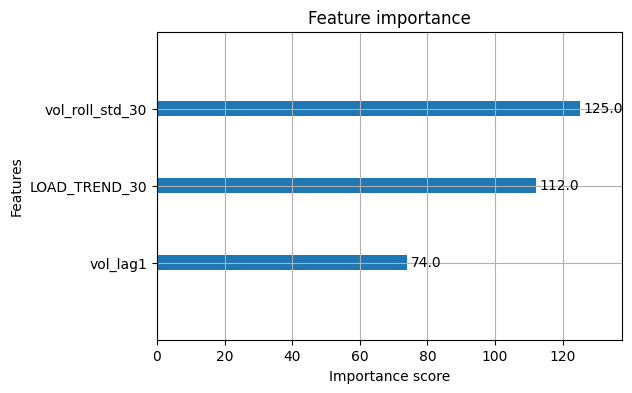

In [174]:
plt.rcParams["figure.figsize"] = (6, 4)
xgb.plot_importance(model);

## Validation

In [147]:
def pooled_spearman_with_ci(df, pred_col='pred_residual', truth_col='true_residual', n_boot=2000, rng=42):
    mask = df[pred_col].notna()
    pooled_rho = spearmanr(df.loc[mask, pred_col], df.loc[mask, truth_col]).correlation

    # bootstrap over days (block bootstrap)
    rng = np.random.default_rng(rng)
    unique_days = df.loc[mask, 'DAY_ID'].unique()
    day_groups = {d: df.loc[(df['DAY_ID']==d) & mask, [pred_col, truth_col]].values for d in unique_days}

    boots = []
    for _ in range(n_boot):
        sample_days = rng.choice(unique_days, size=len(unique_days), replace=True)
        preds = []
        trues = []
        for d in sample_days:
            arr = day_groups[d]
            preds.append(arr[:,0])
            trues.append(arr[:,1])
        preds = np.concatenate(preds)
        trues = np.concatenate(trues)
        boots.append(spearmanr(preds, trues).correlation)
    lo, hi = np.nanpercentile(boots, [2.5, 97.5])
    return pooled_rho, (lo, hi)

mask = df['pred_residual'].notna()
pooled_rho, ci = pooled_spearman_with_ci(df)
print(f"Pooled overall Spearman: {pooled_rho:.4f} (95% CI {ci[0]:.3f}, {ci[1]:.3f})")

# per-country
for c in df.loc[mask, 'COUNTRY'].unique():
    m = df['COUNTRY']==c
    r = spearmanr(df.loc[m & mask,'pred_residual'], df.loc[m & mask,'true_residual']).correlation
    print(f"{c}: pooled rho {r:.4f}, n={df.loc[m & mask].shape[0]}")


Pooled overall Spearman: 0.3057 (95% CI 0.216, 0.393)
DE: pooled rho 0.1024, n=177
FR: pooled rho 0.1421, n=252


Rolling test Spearman mean: 0.33112062221503646
median: 0.3940779815330684 IQR: [0.20952819 0.44962386]
std: 0.17397246870375943


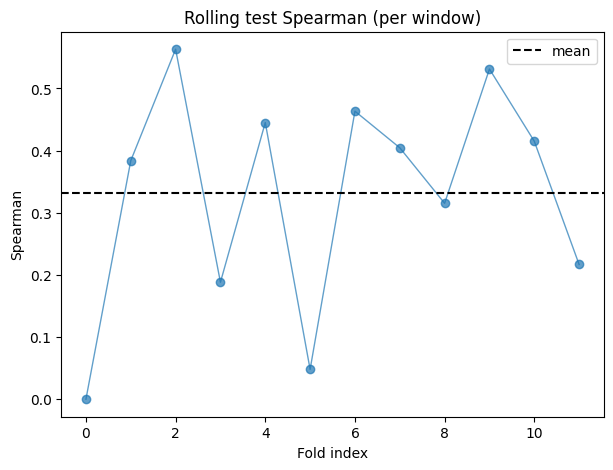

In [148]:
vals = np.array(rolling_test_spearman)
print("Rolling test Spearman mean:", np.nanmean(vals))
print("median:", np.nanmedian(vals), "IQR:", np.nanpercentile(vals, [25,75]))
print("std:", np.nanstd(vals))

# timeseries quick visual
plt.plot(vals, marker='o', linewidth=1, alpha=0.7)
plt.title("Rolling test Spearman (per window)")
plt.ylabel("Spearman")
plt.xlabel("Fold index")
plt.axhline(np.nanmean(vals), color='k', linestyle='--', label='mean')
plt.legend()
plt.show()

In [159]:
# prepare rank training df
rank_train_df = df.loc[train_mask, ['DAY_ID'] + features + ['residual_target', 'COUNTRY']].copy()
rank_train_df = rank_train_df.sort_values(['DAY_ID','COUNTRY']).reset_index(drop=True)
groups = rank_train_df.groupby('DAY_ID').size().tolist()
labels = rank_train_df['residual_target'].values

dtrain_rank = xgb.DMatrix(rank_train_df[features], label=labels)
dtrain_rank.set_group(groups)

params_rank = params.copy()
params_rank['objective'] = 'rank:pairwise'
# consider ndcg instead:
# params_rank['objective'] = 'rank:ndcg'
# params_rank['eval_metric'] = 'ndcg@5'
params_rank['eval_metric'] = 'ndcg'

model_rank = xgb.train(
    params_rank,
    dtrain_rank,
    num_boost_round=1000,
    # no early stopping that uses group validation here; you can build a holdout per-day group val if desired
    verbose_eval=False
)

# prediction and per-day spearman
hold_df = df.loc[holdout_mask, ['DAY_ID', 'COUNTRY'] + features + ['residual_target']].copy()
hold_df = hold_df.sort_values(['DAY_ID','COUNTRY']).reset_index(drop=True)
pred_hold_rank = model_rank.predict(xgb.DMatrix(hold_df[features]))


day_rhos = []
for d, sub in hold_df.groupby('DAY_ID'):
    if len(sub) < 2: 
        continue

    idx = sub.index.values
    rho = spearmanr(pred_hold_rank[idx], sub['residual_target']).correlation

    if not np.isnan(rho):
        day_rhos.append(rho)

log.info(f'Mean holdout Spearman for rank model (day-averaged): {np.nanmean(day_rhos):.4f}')

2026-02-05 20:04:11,387 INFO Mean holdout Spearman for rank model (day-averaged): 0.6207


In [158]:
def per_day_spearman(df, pred_col='pred_residual', truth_col='true_residual', min_per_day=2):
    mask = df[pred_col].notna() & df[truth_col].notna()
    grouped = df.loc[mask].groupby('DAY_ID')

    rhos = []
    counts = []

    for d, g in grouped:
        if len(g) < min_per_day:
            continue
        rho = spearmanr(g[pred_col], g[truth_col]).correlation
        if not np.isnan(rho):
            rhos.append(rho)
            counts.append(len(g))

    return np.array(rhos), np.array(counts)

day_rhos, counts = per_day_spearman(df)

print("Per-day rho mean:", np.mean(day_rhos))
print("median:", np.median(day_rhos))
print("count:", len(day_rhos))
print("Top-k accuracy (days):", 100*np.mean(day_rhos > 0))


Per-day rho mean: 0.5141242937853105
median: 0.9999999999999999
count: 177
Top-k accuracy (days): 75.70621468926554


In [160]:
# train/val split for early stopping
X_hold_train = df.loc[train_mask, features]
y_hold_train = df.loc[train_mask, 'volatility']
X_hold_test = df.loc[holdout_mask, features]
y_hold_test = df.loc[holdout_mask, 'volatility']

split = int(0.85 * len(X_hold_train))
dtr2 = xgb.DMatrix(X_hold_train.iloc[:split], label=y_hold_train.iloc[:split])
dval = xgb.DMatrix(X_hold_train.iloc[split:], label=y_hold_train.iloc[split:])
dte = xgb.DMatrix(X_hold_test)

model_raw = xgb.train(
    params,
    dtr2,
    num_boost_round=1000,
    evals=[(dtr2, 'train'), (dval, 'val')],
    early_stopping_rounds=50,
    verbose_eval=False
)

pred_raw = model_raw.predict(dte)
rho_raw = spearmanr(pred_raw, y_hold_test.values).correlation
log.info(f'Pure ML holdout Spearman (volatility): {rho_raw:.4f}')

# also compare to GARCH-only, GARCH+ML:
mask = ~np.isnan(df['garch_vol']) & (df['DAY_ID'].isin(holdout_days))
garch_only_rho = spearmanr(df.loc[mask,'garch_vol'], df.loc[mask,'volatility']).correlation
log.info(f'GARCH-only holdout Spearman: {garch_only_rho:.4f}')


2026-02-05 20:04:18,268 INFO Pure ML holdout Spearman (volatility): -0.0867
2026-02-05 20:04:18,270 INFO GARCH-only holdout Spearman: 0.0173


In [153]:
import numpy as np
from scipy.stats import spearmanr

rng = np.random.default_rng(123)
# choose test_preds/test_truth as arrays of same length
obs_rho = spearmanr(test_preds, test_truth).correlation

n_perm = 2000
count = 0
for _ in range(n_perm):
    shuffled = rng.permutation(test_truth)       # if you want preserve day blocks, shuffle at day level
    rho_null = spearmanr(test_preds, shuffled).correlation
    if abs(rho_null) >= abs(obs_rho):
        count += 1
p_empirical = (count + 1) / (n_perm + 1)
log.info(f'Empirical permutation p-value: {p_empirical:.4f}')


2026-02-05 19:37:09,842 INFO Empirical permutation p-value: 0.0005


In [155]:
# block shuffle: shuffle day-level arrays
days = hold_df['DAY_ID'].unique()
day_to_idx = {d: hold_df[hold_df['DAY_ID']==d].index.values for d in days}
orig_truth_blocks = [hold_df.loc[day_to_idx[d], 'residual_target'].values for d in days]
orig_pred_blocks = [test_preds[day_to_idx[d]] for d in days]

for _ in range(n_perm):
    perm_days = rng.permutation(len(days))
    shuffled_truth = np.concatenate([orig_truth_blocks[i] for i in perm_days])
    rho_null = spearmanr(np.concatenate(orig_pred_blocks), shuffled_truth).correlation
    if abs(rho_null) >= abs(obs_rho):
        count += 1
p_empirical = (count + 1) / (n_perm + 1)
log.info(f'Empirical permutation p-value: {p_empirical:.4f}')

2026-02-05 19:37:55,369 INFO Empirical permutation p-value: 0.0015


In [156]:
def precision_at_k_per_day(df, pred_col='pred_residual', truth_col='true_residual', k_frac=0.1):
    mask = df[pred_col].notna()
    precisions = []
    for d, g in df.loc[mask].groupby('DAY_ID'):
        n = len(g)
        k = max(1, int(np.ceil(k_frac*n)))
        top_pred = g.nlargest(k, pred_col)
        top_true = g.nlargest(k, truth_col)
        prec = len(set(top_pred.index).intersection(top_true.index)) / k
        precisions.append(prec)
    return np.mean(precisions), np.std(precisions)

prec_mean, prec_std = precision_at_k_per_day(df)
print(f"Precision@10% mean: {prec_mean:.3f} (std {prec_std:.3f})")


Precision@10% mean: 0.829 (std 0.376)


## Trading strategy

In [143]:
# -----------------------
# Trading strategy 
# -----------------------
# Build backtest table from df rows that have predictions
bt = df.loc[df['pred_residual'].notna(), ['DAY_ID', 'COUNTRY', 'pred_residual', 'residual_target', 'volatility']].copy()
bt = bt.rename(columns={'pred_residual': 'pred', 'residual_target': 'true_res'})
# ensure correct sorted order
bt = bt.sort_values(['COUNTRY', 'DAY_ID']).reset_index(drop=True)

# Cross-sectional normalization per day
bt['pred_cs'] = bt['pred'] - bt.groupby('DAY_ID')['pred'].transform('mean')
bt['vol_cs'] = bt['true_res'] - bt.groupby('DAY_ID')['true_res'].transform('mean')

# rolling z-score per country - compute past mean/std only (shift by 1)
lookback = 30
bt['pred_mean_past'] = bt.groupby('COUNTRY')['pred_cs'].transform(lambda x: x.rolling(lookback, min_periods=5).mean().shift(1))
bt['pred_std_past'] = bt.groupby('COUNTRY')['pred_cs'].transform(lambda x: x.rolling(lookback, min_periods=5).std().shift(1))
# avoid div by zero
bt['pred_std_past'] = bt['pred_std_past'].fillna(bt['pred_std_past'].median()).replace(0, 1e-6)

bt['z'] = (bt['pred_cs'] - bt['pred_mean_past']) / bt['pred_std_past']
bt['z'] = bt['z'].fillna(0)

# threshold signal
threshold = 0.5
bt['signal_raw'] = np.where(bt['z'].abs() > threshold, bt['z'], 0)
# clip
bt['signal'] = bt['signal_raw'].clip(-2, 2)

# Position sizing: normalize daily so sum(abs(position)) = 1 (equal absolute exposure across days)
bt['abs_sig'] = bt.groupby('DAY_ID')['signal'].transform(lambda x: x.abs())
# To avoid division by zero, compute per day sum of abs
daily_abs = bt.groupby('DAY_ID')['abs_sig'].transform('sum').replace(0, np.nan)
bt['position'] = bt['signal'] / daily_abs
bt['position'] = bt['position'].fillna(0)

# Transaction costs model: cost per turnover * abs(change in position)
cost_bps = 0.0005  # 0.05% per unit notional (adjust as realistic)
# compute turnover per country as change in position day-to-day
bt['prev_pos'] = bt.groupby('COUNTRY')['position'].shift(1).fillna(0)
bt['turnover'] = (bt['position'] - bt['prev_pos']).abs()
bt['tcost'] = bt['turnover'] * cost_bps

# PnL (simple): position * vol_cs  - tcost
bt['pnl_raw'] = bt['position'] * bt['vol_cs']
bt['pnl'] = bt['pnl_raw'] - bt['tcost']

# Aggregate daily PnL
daily_pnl = bt.groupby('DAY_ID')['pnl'].sum()

# Sharpe (annualized)
sharpe = daily_pnl.mean() / (daily_pnl.std() + 1e-9) * np.sqrt(252)
log.info(f'Sharpe (with costs): {sharpe:.4f}')

# Max drawdown
cum = daily_pnl.cumsum()
roll_max = cum.cummax()
drawdown = cum - roll_max
max_dd = drawdown.min()
log.info(f'Max drawdown: {max_dd:.4f}')

# Turnover summary
avg_turnover = bt.groupby('DAY_ID')['turnover'].sum().mean()
log.info(f'Average daily turnover (sum abs): {avg_turnover:.6f}')

# threshold sweep to find best threshold (recompute quickly)
best_sharpe = -np.inf
best_thr = None
for thr in np.arange(0.3, 1.6, 0.1):
    bt['signal_tmp'] = np.where(bt['z'].abs() > thr, bt['z'], 0)
    bt['signal_tmp'] = bt['signal_tmp'].clip(-2, 2)
    bt['abs_sig_tmp'] = bt.groupby('DAY_ID')['signal_tmp'].transform(lambda x: x.abs())
    daily_abs_tmp = bt.groupby('DAY_ID')['abs_sig_tmp'].transform('sum').replace(0, np.nan)
    bt['pos_tmp'] = (bt['signal_tmp'] / daily_abs_tmp).fillna(0)
    bt['prev_pos_tmp'] = bt.groupby('COUNTRY')['pos_tmp'].shift(1).fillna(0)
    bt['turn_tmp'] = (bt['pos_tmp'] - bt['prev_pos_tmp']).abs()
    bt['tcost_tmp'] = bt['turn_tmp'] * cost_bps
    bt['pnl_tmp'] = (bt['pos_tmp'] * bt['vol_cs']) - bt['tcost_tmp']
    daily_pnl_tmp = bt.groupby('DAY_ID')['pnl_tmp'].sum()
    sharpe_tmp = daily_pnl_tmp.mean() / (daily_pnl_tmp.std() + 1e-9) * np.sqrt(252)
    if sharpe_tmp > best_sharpe:
        best_sharpe = sharpe_tmp
        best_thr = thr

log.info(f'Optimal threshold (sweep): {best_thr:.2f}, Sharpe: {best_sharpe:.4f}')

2026-02-05 16:20:35,742 INFO Sharpe (with costs): 1.9370
2026-02-05 16:20:35,743 INFO Max drawdown: -8.3689
2026-02-05 16:20:35,743 INFO Average daily turnover (sum abs): 0.817376
2026-02-05 16:20:35,988 INFO Optimal threshold (sweep): 0.80, Sharpe: 2.3854


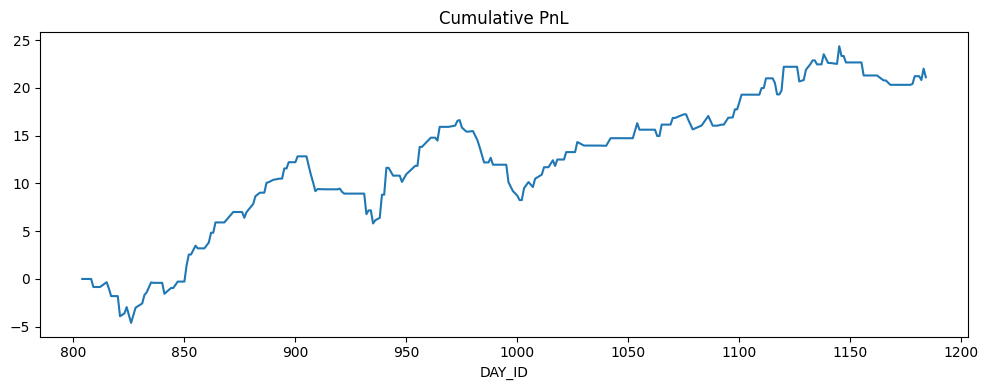

In [144]:
try:
    plt.figure(figsize=(10,4))
    daily_pnl.cumsum().plot(title='Cumulative PnL')
    plt.tight_layout()
    plt.savefig(os.path.join(out_dir, 'cum_pnl.png'))
    plt.close()
except Exception:
    pass